In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
import numpy as np
import librosa
from pathlib import Path
import seaborn as sns
import pandas as pd
import thinkdsp
from matplotlib import pyplot as plt
from typing import Dict, List, Tuple, Union

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


In [3]:
import optuna

from tqdm import trange

In [4]:
TRAINPATH="SimpleData/train"
TESTPATH="SimpleData/test"

In [5]:
@dataclass
class Features:
    sample_rate: int = 22050
    hop_length: int = 220
    n_fft: int = 2048
    n_frames_per_example: int = 1


def load_wav(path: Union[str, Path], sample_rate: int) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=sample_rate)
    return waveform


def extract_features(file_path: Union[str, Path], params: Features) -> List[np.ndarray]:
    waveform = load_wav(file_path, sample_rate=params.sample_rate)

    spectrogram = librosa.feature.melspectrogram(
        y=waveform, n_fft=params.n_fft, hop_length=params.hop_length
    )

    spectrogram = np.log(1e-20 + np.abs(spectrogram**2))

    n_examples = spectrogram.shape[1] // params.n_frames_per_example

    return [
        spectrogram[
            :, i * params.n_frames_per_example : (i + 1) * params.n_frames_per_example
        ].reshape(1, -1)
        for i in range(n_examples)
    ]

数据预处理 data preprocessing

In [6]:
def load_folder_data(
    path: Path, train: bool, params: Features
) -> Tuple[List[List[np.ndarray]], List[List[str]], List[Path]]:
    features: List[List[np.ndarray]] = []
    labels: List[List[str]] = []
    file_names: List[Path] = list(path.rglob("*.wav"))

    for file_path in file_names:
        file_features = extract_features(file_path, params)

        features.append(file_features)

        if train:
            class_name = file_path.parent.name
            labels.append([class_name] * len(file_features))

    return features, labels, file_names

In [7]:
@dataclass
class ExpConfig:
    features: Features = Features(
        sample_rate=22050,
        hop_length=220,
        n_fft=2048,
        n_frames_per_example=1,
    )
    random_state: int = 42
    test_size: float = 0.1
    train_path: Path = Path(TRAINPATH)
    test_path: Path = Path(TESTPATH)

config = ExpConfig()

In [8]:
class_names = [folder.name for folder in config.train_path.iterdir()]

class_name2id: Dict[str, int] = {
    class_name: class_id for class_id, class_name in enumerate(class_names)
}

features, labels, file_names = load_folder_data(
    path=config.train_path, train=True, params=config.features
)

In [9]:
labels_int: List[List[int]] = [
    [class_name2id[label] for label in label_list] for label_list in labels
]

In [10]:
(
    features_train,
    features_test,
    labels_train,
    labels_test,
    files_train,
    files_test,
) = train_test_split(
    features,
    labels_int,
    file_names,
    random_state=config.random_state,
    test_size=config.test_size,
)

In [11]:
X_train = np.vstack([x for list_ in features_train for x in list_])
y_train = np.array([x for list_ in labels_train for x in list_])

In [12]:
X_train.shape

(2438084, 128)

第一个封装好的pipeline,采用了标准化和SGD分类器(用来augment data)
First pipeline, using standardization and SGD classifier，(used to augment data)

In [13]:
from sklearn.linear_model import SGDClassifier
pipe1 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SGDClassifier(loss='log_loss'))]
).fit(X_train, y_train)

增强训练数据
Augment training data

In [14]:
# incorrect_predicted = np.empty(shape=(0,), dtype=int)
#
# for i in range(len(features_train)):
#     pred_proba = pipe1.predict_proba(np.vstack(features_train[i]))
#     pred = pred_proba.mean(0)
#     most_probable = np.argmax(pred)
#     if class_names[most_probable] != str(files_train[i]).split('\\')[-2]:
#         incorrect_predicted = np.append(incorrect_predicted, i)

In [15]:
# random_idx = np.random.randint(0, X_train.shape[0], size=30_000)
# incorrect_predicted = np.unique(np.append(incorrect_predicted, random_idx))
# X_train_augmented = X_train[incorrect_predicted]
# y_train_augmented = y_train[incorrect_predicted]

In [16]:
# X_train=X_train_augmented
# Y_train=y_train_augmented

第二个封装好的pipeline,采用了标准化和决策树分类器
Second pipeline, using standardization and decision tree classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier
pipe_DecisionTreeClassifier = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", DecisionTreeClassifier())]
).fit(X_train, y_train)

第三个封装好的pipeline,采用了标准化和K近邻分类器
Third pipeline, using standardization and KNN classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier

pipe_KNeighborsClassifier = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=3))]
).fit(X_train, y_train)


第四个封装好的pipeline,采用了标准化和随机森林分类器
Fourth pipeline, using standardization and random forest classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
#
# def objective(trial):
#     n_estimators = trial.suggest_int("n_estimators", 2, 800)
#     max_depth = int(trial.suggest_float("max_depth", 1, 128, log=True))
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
#     clf = RandomForestClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=config.random_state,
#     )
#     pipe_RandomForestClassifier = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", clf)]
#     ).fit(X_train, y_train)
#     return pipe_RandomForestClassifier.score(X_train, y_train)
#
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)
# print("best_params",study.best_params)
# print("best_trial",study.best_trial)



In [20]:
pipe_RandomForestClassifier= Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=595, max_depth=95, min_samples_split=7, min_samples_leaf=1, random_state=config.random_state))]
).fit(X_train, y_train)


第五个封装好的pipeline,采用了标准化和线性支持向量机分类器
Fifth pipeline, using standardization and linear support vector machine classifier

In [31]:
from sklearn.svm import LinearSVC

pipe_LinearSVC = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(max_iter=500,verbose=True,multi_class='ovr',dual="auto"))
]
).fit(X_train, y_train)


InvalidParameterError: The 'dual' parameter of LinearSVC must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int' or a str among {'auto'}. Got 'false' instead.

In [22]:
from sklearn.naive_bayes import MultinomialNB
#
# pipe_MultinomialNB = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MultinomialNB())]
# ).fit(X_train, y_train)

In [23]:
# from sklearn.neural_network import MLPClassifier
#
# pipe_MLPClassifier = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(max_iter=1000,verbose=True))]
# ).fit(X_train, y_train)

In [24]:

def plot_conf_matrix(
    y_test: np.ndarray, y_pred: np.ndarray, class_names: List[str], annot: bool = False
) -> None:
    plt.figure(figsize=(8, 6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.2f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        annot=annot,
    )
    plt.show()

决策树分类器的混淆矩阵
Confusion matrix of decision tree classifier

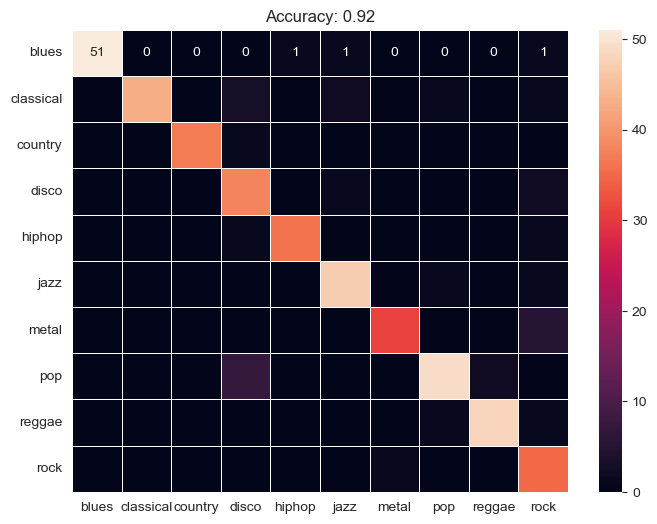

In [25]:
y_pred = np.array(
    [
        pipe_DecisionTreeClassifier.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

K近邻分类器的混淆矩阵
Confusion matrix of KNN classifier

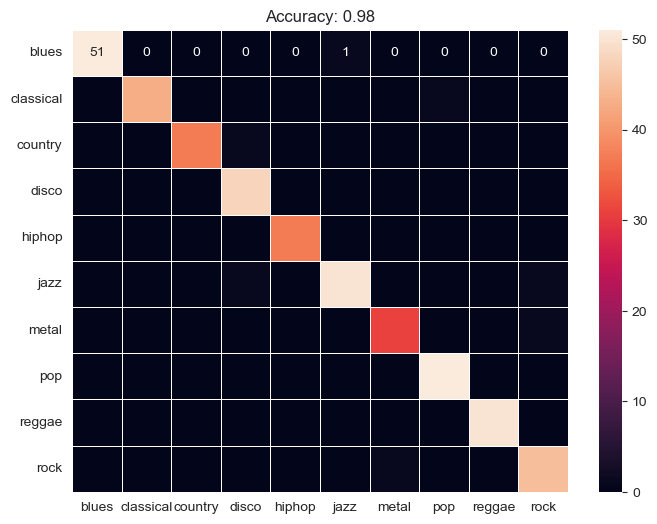

In [26]:
y_pred = np.array(
    [
        pipe_KNeighborsClassifier.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

随机森林分类器的混淆矩阵
Confusion matrix of random forest classifier

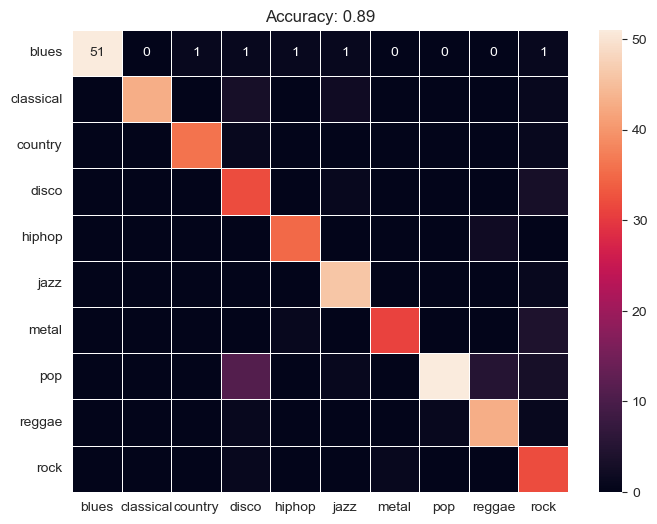

In [27]:
y_pred = np.array(
    [
        pipe_RandomForestClassifier.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

线性支持向量机分类器的混淆矩阵

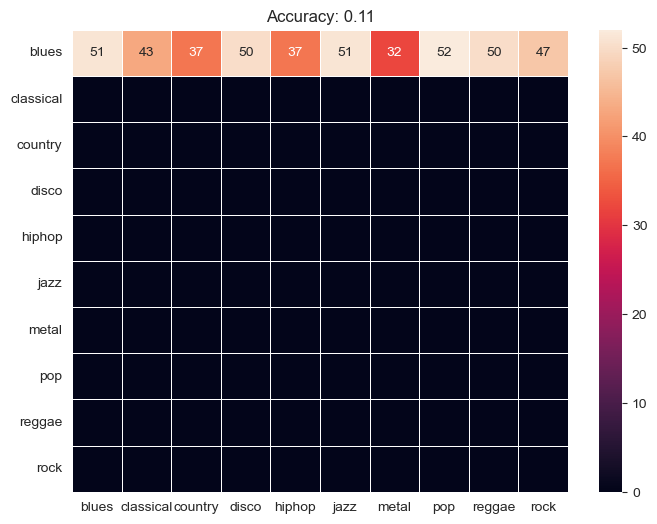

In [30]:
# y_pred = np.array(
#     [
#         pipe_LinearSVC.predict(np.vstack(feature_list)).mean(0).argmax()
#         for feature_list in features_test
#     ]
# )
#
# y_test = np.array([label_list[0] for label_list in labels_test])
#
# plot_conf_matrix(y_pred, y_test, class_names, annot=True)

SGD分类器的混淆矩阵
confusion matrix of SGD classifier

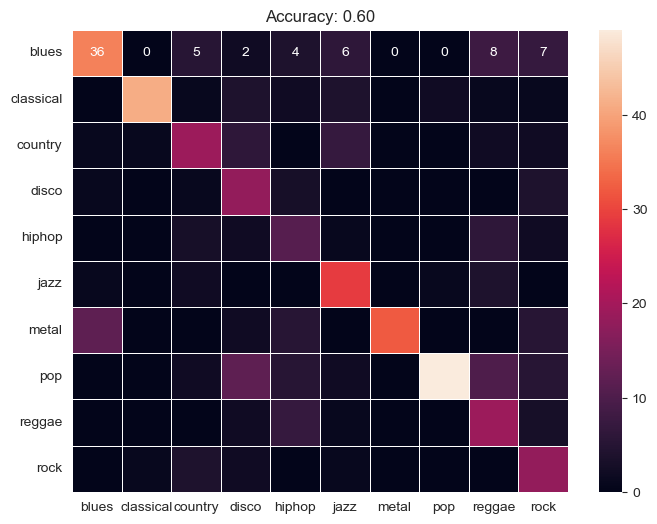

In [29]:
y_pred = np.array(
    [
        pipe1.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

In [ ]:
# test_features, _, test_pathes = load_folder_data(
#     config.test_path, train=False, params=config.features
# )

In [ ]:
# predictions = [
#     class_names[pipe_KNeighborsClassifier.predict_proba(np.vstack(test_feature)).mean(0).argmax()]
#     for test_feature in test_features
# ]

In [ ]:
# (
#     pd.DataFrame(
#         {
#             "index": [
#                 test_wav_path.name for test_wav_path in config.test_path.iterdir()
#             ],
#             "genre": predictions,
#         }
#     ).to_csv("submit.csv", index=False)
# )

In [ ]:
# import joblib
# joblib.dump(pipe_DecisionTreeClassifier, "pipe_DecisionTreeClassifier.pkl")
# joblib.dump(pipe_KNeighborsClassifier, "pipe_KNeighborsClassifier.pkl")
# joblib.dump(pipe_RandomForestClassifier, "pipe_RandomForestClassifier.pkl")
# joblib.dump(pipe_LinearSVC, "pipe_LinearSVC.pkl")